In [17]:
# Set up
%pylab inline

# Params
DATADIR = "/storage/mgymrek/gtex-estrs/revision/"
RESULTSDIR = "/storage/mgymrek/gtex-estrs/revision/figures"

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Import libraries
import os
import pandas as pd
import scipy.stats
import seaborn as sns
import statsmodels.stats.multitest
from sklearn.cluster import KMeans

############ Set up paths #############
SAVEPLOT = True
MIN_CAUSAL_SCORE = 0.5 
GENEANNOT = "/storage/resources/dbase/human/hg19/gencode_gene_annotations_hg19.csv"

allstrs = pd.read_csv(os.path.join(DATADIR, "misc", "all_analyzed_strs.tab"), sep="\t")

# Load eSTRs
estrs = pd.read_csv(os.path.join(RESULTSDIR, "SuppTable_CAVIAR.tsv"), sep="\t")
geneannot = pd.read_csv(GENEANNOT)
geneannot["gene"] = geneannot["gene.id"].apply(lambda x: x.split(".")[0])
estrs = pd.merge(estrs, geneannot[["gene", "gene.strand","gene.start","gene.stop"]], on=["gene"])
estrs["motif"] = estrs.apply(lambda x: x["str.motif.forward"] if x["gene.strand"]=="+" else x["str.motif.reverse"], 1)
estrs["dist.tss"] = estrs.apply(lambda x: (x["str.start"]-x["gene.start"]) if x["gene.strand"]=="+" else (x["gene.stop"]-x["str.start"]), 1)

# All ref data
ref = pd.read_csv(os.path.join(DATADIR, "misc", "annotations", "hg19.hipstr_reference_annot.bed"), sep="\t")
ref["str.start"]=ref["start"]
ref = pd.merge(ref, allstrs[["chrom","str.start"]].drop_duplicates(), on=["chrom","str.start"])

causal = estrs[estrs["score"]>=MIN_CAUSAL_SCORE]
rcausal = pd.merge(causal, ref[["chrom","str.start","coding", "5utr","3utr","introns", "hg19_promoter_3kb"]], on=["chrom","str.start"])


Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.4/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [18]:
all_annot = ["all","intergenic","introns","promoter-up", "promoter-down", "5utr", "3utr",  "coding"]

labels = []
num_total = []
num_pos = []
perc = []
xval = []

x = 0

PROMOTERREGION = 3000
INTERGENICREGION = 10000

for annotation in all_annot:
    for period in range(0, 7):   
        d = rcausal
        if period != 0:
            d = rcausal[rcausal["str.motif.forward"].apply(len)==period]
        if annotation != "all": 
            if annotation == "intergenic":
                d = d[(d["introns"]+d["5utr"]+d["3utr"]+d["coding"])==0]
                d = d[d["dist.tss"].apply(abs) >= INTERGENICREGION]
            elif annotation == "promoter-up":
                d = d[(d["dist.tss"]>-1*PROMOTERREGION) & (d["dist.tss"]<0)]
            elif annotation == "promoter-down":
                d = d[(d["dist.tss"]>0) & (d["dist.tss"]<PROMOTERREGION)]
            else:
                d = d[d[annotation]>0]
        if d.shape[0] <= 3: continue
        labels.append(("%s:%s"%(annotation, period)).replace("_",""))
        num_total.append(d.shape[0])
        num_pos.append(d[d["beta"]>0].shape[0])
        if num_total[-1] > 0:
            perc.append(num_pos[-1]*1.0/num_total[-1])
        else: perc.append(np.nan)
        xval.append(x)
        x += 1
    x += 5

In [19]:
dirdata = pd.DataFrame({"label": labels, "total": num_total, "pos": num_pos,"perc": perc, "xval": xval})
dirdata.loc[dirdata["total"]<3,"perc"] = np.nan

def GetStderr(perc, total):
    if total == 0: return np.nan
    elif perc < 1:
        return 1.96*np.sqrt(perc*(1-perc)/total)
    else:
        return 3.0 
    
dirdata["stderr"] = dirdata.apply(lambda x: GetStderr(x["perc"],x["total"]), 1)
# pvals.append(scipy.stats.binom_test(perc*df_bin.shape[0], df_bin.shape[0]))
dirdata["pval"] = dirdata.apply(lambda x: scipy.stats.binom_test(x["pos"], x["total"]), 1)


In [20]:
dirdata.sort_values("pval")

,label,perc,pos,total,xval,stderr,pval
6,all:6,0.769231,20,26,6,0.161952,0.009355
19,introns:6,0.846154,11,13,29,0.196134,0.022461
26,promoter-down:2,0.769231,10,13,46,0.229035,0.092285
23,promoter-up:6,1.000000,4,4,38,3.000000,0.125000
24,promoter-down:0,0.603774,32,53,44,0.131682,0.168978
20,promoter-up:0,0.633333,19,30,35,0.172444,0.200488
10,intergenic:3,0.166667,1,6,15,0.298205,0.218750
31,5utr:0,0.650000,13,20,56,0.209041,0.263176
3,all:3,0.387097,12,31,3,0.171467,0.281042
15,introns:2,0.547619,69,126,25,0.086908,0.327123


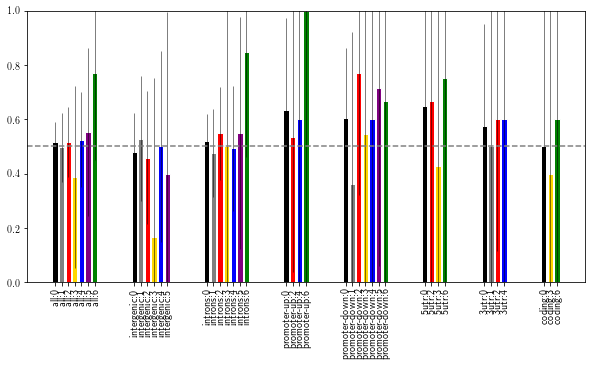

In [21]:
colors = ["black","gray","red","gold","blue","purple","green"]
dirdata["period"] = dirdata["label"].apply(lambda x: int(x.split(":")[1]))
dirdata["color"] = dirdata["period"].apply(lambda x: colors[x])
fig = plt.figure()
fig.set_size_inches((10, 5))
ax = fig.add_subplot(111)
ax.bar(dirdata["xval"], dirdata["perc"], yerr=1.96*dirdata["stderr"],
       color=dirdata["color"], edgecolor="white", error_kw=dict(lw=0.5, capsize=0, capthick=0.5))
ax.axhline(y=0.5, linestyle="dashed", color="gray")
ax.set_xticks(dirdata["xval"])
ax.set_xticklabels(dirdata["label"], rotation=90)
ax.set_ylim(bottom=0, top=1);
fig.savefig(os.path.join(RESULTSDIR, "SuppFig_StrandBias-A.pdf"))

In [22]:
# By strand
mpairs = [("allA","allT"), ("A","T"),("AC","GT"),("AAC","GTT"), ("AAAC","GTTT")]
labels = []
num_total = []
num_pos = []
perc = []
xval = []
color = []
x = 0
for annotation in ["transcribed","intergenic","promoter-up","promoter-down","introns"]:
    for mpair in mpairs:
        pnums = []
        ppercs = []
        for motif in mpair:
            if motif == "allA":
                d = rcausal[rcausal["motif"].apply(lambda x: x in ["A","AC","AAC","AAAC"])]
            elif motif == "allT":
                d = rcausal[rcausal["motif"].apply(lambda x: x in ["T","GT","GTT","GTTT"])]
            else:
                d = rcausal[rcausal["motif"]==motif]
            if annotation != "all": 
                if annotation == "intergenic":
                    d = d[(d["introns"]+d["5utr"]+d["3utr"]+d["coding"])==0]
                    d = d[d["dist.tss"].apply(abs)>=INTERGENICREGION]
                elif annotation == "transcribed":
                    d = d[(d["introns"]+d["5utr"]+d["3utr"]+d["coding"])>0]
                elif annotation == "promoter-up":
                    d = d[(d["dist.tss"]>-1*PROMOTERREGION) & (d["dist.tss"]<0)]
                elif annotation == "promoter-down":
                    d = d[(d["dist.tss"]>0) & (d["dist.tss"]<PROMOTERREGION)]
                else:
                    d = d[d[annotation]>0]
            if d.shape[0] <=3: continue
            labels.append(("%s:%s"%(annotation, motif)).replace("_",""))
            num_total.append(d.shape[0])
            #print("%s:%s:%s"%(annotation,motif, num_total[-1]))
            #count.append(r.shape[0])
            num_pos.append(d[d["beta"]>0].shape[0])
            if num_total[-1] > 0:
                perc.append(num_pos[-1]*1.0/num_total[-1])
            else:
                perc.append(np.nan)
            xval.append(x)
            if "A" in motif: color.append("gray")
            else: color.append("RED")
            x += 1
            pnums.append(num_total[-1])
            ppercs.append(perc[-1])
        if len(pnums) != 2: continue
        # Test diff in direction of effect
        pooled_prop = (ppercs[0]*pnums[0]+ppercs[1]*pnums[1])/(sum(pnums))
        pooled_se = np.sqrt(pooled_prop*(1-pooled_prop)*(1.0/pnums[0]+1.0/pnums[1]))
        prop_z = (ppercs[0]-ppercs[1])/pooled_se
        prop_p = scipy.stats.norm.sf(abs(prop_z))*2 
        print("%s %s: perc diff p=%.2f"%(annotation, str(mpair), prop_p))
        # Test diff in total numbers
        print("%s %s: total count diff: perc=%.2f p=%.5f"%(annotation, str(mpair), pnums[0]*1.0/sum(pnums), scipy.stats.binom_test(pnums[0], sum(pnums))))
    x += 2
    
sdata = pd.DataFrame({"label": labels, "total": num_total, "pos": num_pos,"perc": perc, "xval": xval, "color": color})
#sdata.loc[sdata["total"]<3,"perc"] = np.nan
sdata["stderr"] = sdata.apply(lambda x: GetStderr(x["perc"],x["total"]), 1)
sdata["pval"] = sdata.apply(lambda x: scipy.stats.binom_test(x["pos"], x["total"]), 1)
sdata.sort_values("pval")

transcribed ('allA', 'allT'): perc diff p=0.30
transcribed ('allA', 'allT'): total count diff: perc=0.42 p=0.00903
transcribed ('A', 'T'): perc diff p=0.49
transcribed ('A', 'T'): total count diff: perc=0.49 p=0.93220
transcribed ('AC', 'GT'): perc diff p=1.00
transcribed ('AC', 'GT'): total count diff: perc=0.35 p=0.00171
transcribed ('AAAC', 'GTTT'): perc diff p=0.22
transcribed ('AAAC', 'GTTT'): total count diff: perc=0.36 p=0.28628
intergenic ('allA', 'allT'): perc diff p=0.51
intergenic ('allA', 'allT'): total count diff: perc=0.44 p=0.24292
intergenic ('A', 'T'): perc diff p=0.86
intergenic ('A', 'T'): total count diff: perc=0.43 p=0.27499
intergenic ('AC', 'GT'): perc diff p=0.25
intergenic ('AC', 'GT'): total count diff: perc=0.50 p=1.00000
promoter-up ('allA', 'allT'): perc diff p=0.15
promoter-up ('allA', 'allT'): total count diff: perc=0.50 p=1.00000
promoter-up ('AC', 'GT'): perc diff p=0.03
promoter-up ('AC', 'GT'): total count diff: perc=0.50 p=1.00000
promoter-down ('all

,color,label,perc,pos,total,xval,stderr,pval
21,gray,promoter-down:A,0.000000,0,4,27,0.000000,0.125000
18,RED,promoter-up:GT,0.857143,6,7,22,0.259230,0.125000
20,RED,promoter-down:allT,0.705882,12,17,26,0.216600,0.143463
16,RED,promoter-up:allT,0.777778,7,9,20,0.271617,0.179688
23,RED,promoter-down:GT,0.777778,7,9,29,0.271617,0.179688
19,gray,promoter-down:allA,0.166667,1,6,25,0.298205,0.218750
14,RED,intergenic:GT,0.360000,9,25,16,0.188160,0.229523
5,RED,transcribed:GT,0.571429,44,77,5,0.110536,0.254305
29,RED,introns:GT,0.573529,39,68,37,0.117550,0.274990
1,RED,transcribed:allT,0.545455,90,165,1,0.075977,0.275714


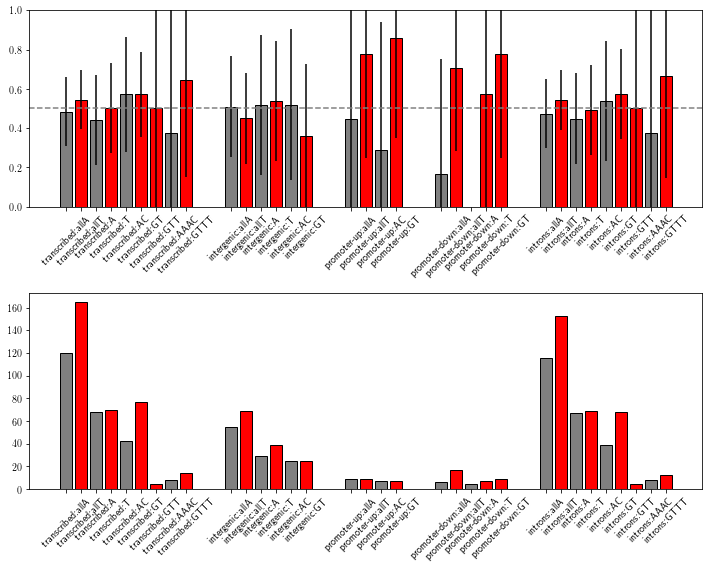

In [23]:
fig = plt.figure()
fig.set_size_inches((10, 8))
ax = fig.add_subplot(211)
ax.bar(sdata["xval"], sdata["perc"], yerr=1.96*sdata["stderr"],
       color=sdata["color"], edgecolor="black")
ax.axhline(y=0.5, linestyle="dashed", color="gray")
ax.set_xticks(sdata["xval"])
ax.set_xticklabels(sdata["label"], rotation=45)
ax.set_ylim(bottom=0, top=1);

ax = fig.add_subplot(212)
ax.bar(sdata["xval"], (sdata["total"]), 
       color=sdata["color"], edgecolor="black")
ax.set_xticks(sdata["xval"])
ax.set_xticklabels(sdata["label"], rotation=45);
fig.tight_layout()
fig.savefig(os.path.join(RESULTSDIR, "SuppFig_StrandBias-B-%s.pdf"%MIN_CAUSAL_SCORE))

In [24]:
d = rcausal[rcausal["motif"]=="T"]
#d = d[(d["introns"]+d["5utr"]+d["3utr"]+d["coding"])==0]
d = d[d["dist.tss"].apply(abs)<PROMOTERREGION]
d[["chrom","str.start","dist.tss"]]

,chrom,str.start,dist.tss
199,chr12,123834462,526
230,chr14,104397470,-2864
355,chr19,36158402,687
417,chr2,242676908,2914
422,chr20,3053936,1670
553,chr6,30642305,-1491
578,chr6,131458278,1472
591,chr7,39018805,1207
610,chr7,129144392,2072
